Referensi:
- https://www.tensorflow.org/tutorials/images/data_augmentation
- https://www.tensorflow.org/tutorials/images/classification 
- https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8 
- https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays/notebook 
- Transfer Learning : https://www.kaggle.com/code/jonaspalucibarbosa/chest-x-ray-pneumonia-cnn-transfer-learning

In [ ]:
# !pip install kaggle

In [1]:
!mkdir -p ~/.kaggle #bikin folder di kaggle root
!cp kaggle.json ~/.kaggle # copy paster kaggle.json ke folder kaggle 

!mkdir ./kaggle #bikin folder kaggle di lokasi sama (bukan di root)
!mv ./kaggle.json ./kaggle #move atau pindahi file kaggle.json ke folder kaggle

In [2]:
!chmod 600 ~/.kaggle/kaggle.json #perizinan akses, hanya pemilik file yang memiliki akses baca dan tulis ke file
!ls ~/.kaggle #cek list data yang ada di folder kaggle

kaggle.json


In [3]:
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

 99% 1.16G/1.17G [00:05<00:00, 216MB/s]
100% 1.17G/1.17G [00:05<00:00, 217MB/s]


In [4]:
!unzip -q /content/labeled-chest-xray-images.zip -d images

In [122]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten

import warnings
warnings.filterwarnings('ignore')

In [123]:
os.listdir('/content/images/chest_xray')

['train', 'test']

In [124]:
main_path= '/content/images/chest_xray'
train_dir= os.path.join(main_path, 'train')
test_dir = os.path.join(main_path, 'test')

In [126]:
num_pneumonia= len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal= len(os.listdir(os.path.join(train_dir, 'NORMAL')))

In [127]:
print(num_pneumonia)
print(num_normal)

3883
1349


In [130]:
train_normal= glob.glob(train_dir + '/NORMAL/*.jpeg')
train_pneumonia= glob.glob(train_dir + '/PNEUMONIA/*.jpeg')

test_normal= glob.glob(test_dir + '/NORMAL/*.jpeg')
test_pneumonia= glob.glob(test_dir + '/PNEUMONIA/*.jpeg')

/content/images/chest_xray/train/NORMAL/NORMAL-1003233-0001.jpeg

In [138]:
def create_dataframe(list_of_images):
  data=[]
  for image in list_of_images:
    data.append((image, image.split('/')[-2]))

  return pd.DataFrame(data, columns= ['images', 'label'])

train_df= create_dataframe(train_normal + train_pneumonia)
train_df= train_df.sample(frac=1, random_state=1).reset_index(drop=True)

test_df= create_dataframe(test_normal + test_pneumonia)
test_df= test_df.sample(frac=1, random_state=1).reset_index(drop=True)


In [139]:
print(train_df.shape)
train_df


(5232, 2)


,images,label
0,/content/images/chest_xray/train/PNEUMONIA/VIR...,PNEUMONIA
1,/content/images/chest_xray/train/PNEUMONIA/BAC...,PNEUMONIA
2,/content/images/chest_xray/train/NORMAL/NORMAL...,NORMAL
3,/content/images/chest_xray/train/NORMAL/NORMAL...,NORMAL
4,/content/images/chest_xray/train/NORMAL/NORMAL...,NORMAL
...,...,...
5227,/content/images/chest_xray/train/NORMAL/NORMAL...,NORMAL
5228,/content/images/chest_xray/train/PNEUMONIA/BAC...,PNEUMONIA
5229,/content/images/chest_xray/train/PNEUMONIA/BAC...,PNEUMONIA
5230,/content/images/chest_xray/train/NORMAL/NORMAL...,NORMAL


In [134]:
print(test_df.shape)

(624, 2)


In [140]:
from sklearn.model_selection import train_test_split
val_df, test_df= train_test_split(test_df, test_size=0.25, random_state=1)
print(test_df.shape)
print(val_df.shape)

(156, 2)
(468, 2)


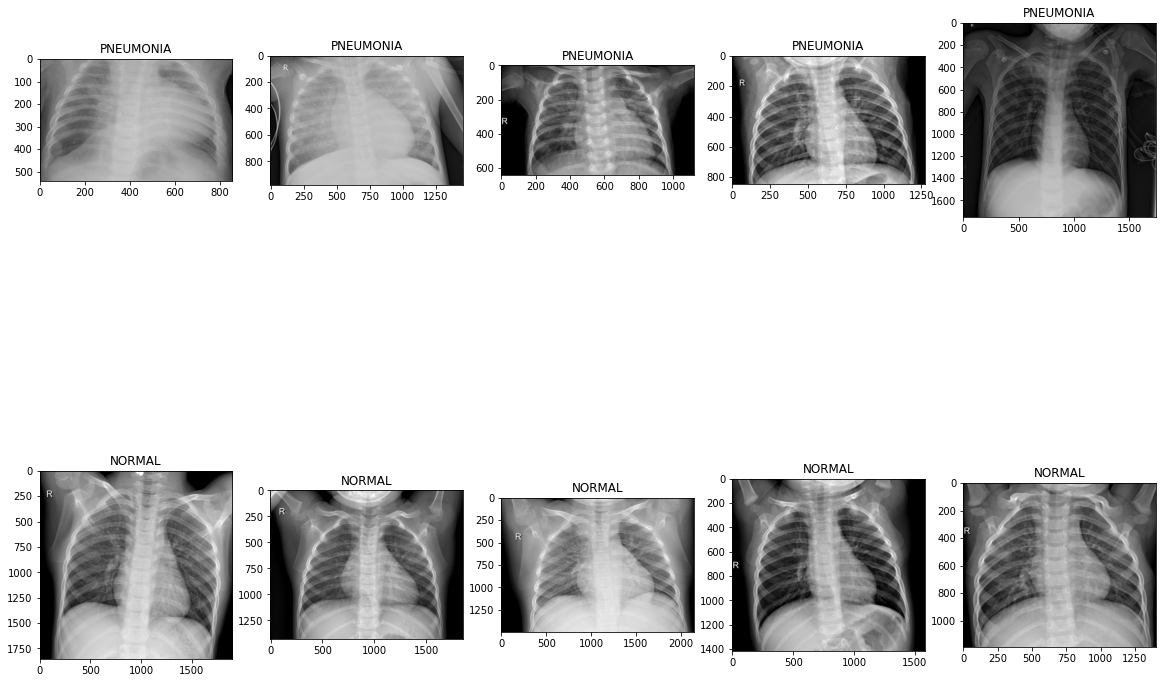

In [141]:
pneumonia_samples= (train_df[train_df['label']=='PNEUMONIA']['images'].iloc[:5]).tolist()
normal_samples= (train_df[train_df['label']=='NORMAL']['images'].iloc[:5]).tolist()

def visualize_samples(samples):
  fig,ax= plt.subplots(nrows=2, ncols=5, figsize= (20,15))
  for i, sample in enumerate(samples):
    img= cv2.imread(sample)
    ax[i//5, i%5].set_title(sample.split('/')[-2])
    ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

visualize_samples(pneumonia_samples + normal_samples)

In [142]:
img_height= 220
img_width= 220
SEED= 1
BATCH= 32

In [143]:
# Augmentasi data
train_datagen= ImageDataGenerator(
    rescale= 1./255,
    rotation_range= 0.2,
    width_shift_range= 0.2,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True
)

val_datagen= ImageDataGenerator(rescale= 1./255)
test_datagen= ImageDataGenerator(rescale= 1./255)


In [144]:
ds_train= train_datagen.flow_from_dataframe(
    dataframe= train_df,
    x_col= 'images',
    y_col= 'label',
    target_size= (img_height,img_width),
    class_mode= 'binary',
    batch_size= BATCH,
    shuffle= True,
    seed= SEED
)

ds_val= val_datagen.flow_from_dataframe(
    dataframe= val_df,
    x_col= 'images',
    y_col= 'label',
    target_size= (img_height,img_width),
    class_mode= 'binary',
    batch_size= BATCH,
    shuffle= False,
    seed= SEED
)

ds_test= test_datagen.flow_from_dataframe(
    dataframe= test_df,
    x_col= 'images',
    y_col= 'label',
    target_size= (img_height,img_width),
    class_mode= 'binary',
    batch_size= BATCH,
    shuffle= False,
    seed= SEED
)

Found 5232 validated image filenames belonging to 2 classes.
Found 468 validated image filenames belonging to 2 classes.
Found 156 validated image filenames belonging to 2 classes.


In [147]:
ds_train.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [148]:
callbacks= [
            EarlyStopping(monitor= 'val_loss', mode='min', patience= 3, verbose=1),
            ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only= True)
            #ReduceLROnPlateau
]

In [149]:
input= [img_height,img_width,3]
#Conv ke 1
model_evita= Sequential()
model_evita.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= input))
model_evita.add(MaxPooling2D(pool_size=2, strides=2))

#Conv ke 2
model_evita.add(Conv2D(filters=32, kernel_size=3, activation= 'relu', input_shape= input))
model_evita.add(MaxPooling2D(pool_size=2, strides=2))

model_evita.add(Flatten())
model_evita.add(Dense(units=128, activation= 'relu'))

model_evita.add(Dense(units=1, activation= 'sigmoid'))

In [150]:
model_evita.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 218, 218, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 109, 109, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 107, 107, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 53, 53, 32)       0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 89888)             0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [153]:
model_evita.compile(optimizer='adam', loss= 'binary_crossentropy', metrics= ['accuracy'])

In [154]:
epochs= 10
history= model_evita.fit(ds_train, batch_size= BATCH, epochs= epochs,
                         validation_data= ds_val, callbacks= callbacks, verbose=1)

Epoch 1/10
164/164 [==============================] - 127s 769ms/step - loss: 0.4643 - accuracy: 0.8301 - val_loss: 0.5527 - val_accuracy: 0.7714
Epoch 2/10
164/164 [==============================] - 120s 734ms/step - loss: 0.2675 - accuracy: 0.8891 - val_loss: 0.5207 - val_accuracy: 0.7799
Epoch 3/10
164/164 [==============================] - 104s 635ms/step - loss: 0.2487 - accuracy: 0.8962 - val_loss: 0.4677 - val_accuracy: 0.8013
Epoch 4/10
164/164 [==============================] - 107s 652ms/step - loss: 0.2288 - accuracy: 0.9025 - val_loss: 0.4639 - val_accuracy: 0.8013
Epoch 5/10
164/164 [==============================] - 102s 619ms/step - loss: 0.2443 - accuracy: 0.9008 - val_loss: 0.3438 - val_accuracy: 0.8397
Epoch 6/10
164/164 [==============================] - 101s 618ms/step - loss: 0.2135 - accuracy: 0.9128 - val_loss: 0.5626 - val_accuracy: 0.7756
Epoch 7/10
164/164 [==============================] - 103s 629ms/step - loss: 0.2059 - accuracy: 0.9169 - val_loss: 0.3049 -

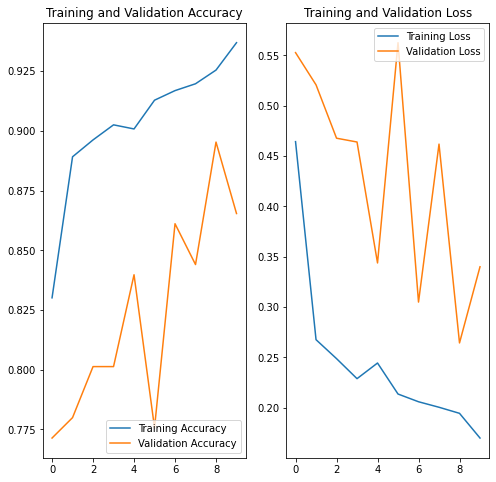

In [155]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = image.load_img(path, target_size=(img_height,img_width)) #inget mesti sesuai input yg sebelumnya
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]

  images = np.vstack([x])
  classes = model_evita.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  print(classes) 
  if classes[0][0] == 1:
    print('pneumonia')
  else:
    print('normal')

In [121]:
history= my_model_icha.fit(ds_train, batch_size= BATCH, 
                           epochs= 7, validation_data= ds_val,
                           callbacks= callbacks1) #bisa atur verbose

Epoch 1/7
131/131 [==============================] - 20s 60ms/step - loss: 11.1955 - accuracy: 0.8641 - val_loss: 0.0946 - val_accuracy: 0.9685
Epoch 2/7
131/131 [==============================] - 4s 32ms/step - loss: 0.1151 - accuracy: 0.9603 - val_loss: 0.1077 - val_accuracy: 0.9694
Epoch 3/7
131/131 [==============================] - 4s 33ms/step - loss: 0.0624 - accuracy: 0.9761 - val_loss: 0.0457 - val_accuracy: 0.9847
Epoch 4/7
131/131 [==============================] - 4s 33ms/step - loss: 0.0738 - accuracy: 0.9728 - val_loss: 0.0373 - val_accuracy: 0.9895
Epoch 5/7
131/131 [==============================] - 4s 33ms/step - loss: 0.0459 - accuracy: 0.9859 - val_loss: 0.0155 - val_accuracy: 0.9952
Epoch 6/7
131/131 [==============================] - 4s 31ms/step - loss: 0.0346 - accuracy: 0.9866 - val_loss: 0.0682 - val_accuracy: 0.9780
Epoch 7/7
131/131 [==============================] - 4s 31ms/step - loss: 0.0203 - accuracy: 0.9938 - val_loss: 0.0210 - val_accuracy: 0.9952
